# <span style="color:rgb(160,0,86)">Regressionsanalyse</span>

***

## <span style="color:rgb(160,0,86)">Lernziele</span>

- Sie können eine **multiple lineare Regression** durchführen.
- Sie verstehen den Unterschied zwischen einer *in-Sample* und einer *out-of-Sample* Validierung und können eine **Kreuzvalidierung** durchführen.  
- Sie können nominale Merkmale mit **Faktorvariablen** in ein Modell einbeziehen.
- Sie können eine **Vorwärtsselektion** durchführen.  

***

### <span style="color:rgb(160,0,86)">Was ist eine multiple lineare Regression?</span>

Bei einer **multiplen linearen Regression** werden mehrere Einflussgrössen (Prädiktoren) in einem linearen Modell gleichzeitig betrachtet:
$$\;\;y = \texttt{predict}(x_1,x_2,\ldots,x_n) = a_1\cdot x_1 + a_2\cdot x_2 + \ldots a_n\cdot x_n + b$$

Wieder aus einer Stichprobe werden die **Regressionskoeffizienten** $\pmb{\hat{a}_1}, \pmb{\hat{a}_2}, \ldots, \pmb{\hat{a}_n}$ geschätzt. Das Vorgehen und die Analyse sind sonst identisch. Einzig beim **Standardfehler der Residuen** wird die ***Anzahl Prädiktoren*** $\pmb{p}$ berücksichtigt: $$\pmb{\mathsf{RSE} = \sqrt{\frac{\mathsf{RSS}}{n-p-1}}=\sqrt{\frac{r_1^2+r_2^2+r_3^2+\ldots+r_n^2}{n-p-1}} }$$  

Ein weiterer Punkt ist, dass wir die Daten nicht mehr in einem Bild darstellen können. Wir müssen uns auf die Rechnungen verlassen.

***

#### <span style="color:rgb(160,0,86)">Beispiele:</span>

Wir betrachen ein Beispiel aus der Marktforschung, in dem der Einfluss von Werbung auf den Verkauf eines Gutes untersucht wird:



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

werbung = pd.read_csv("Daten/Werbung.csv")
werbung.head()

,Unnamed: 0,TV,Radio,Zeitung,Verkauf
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


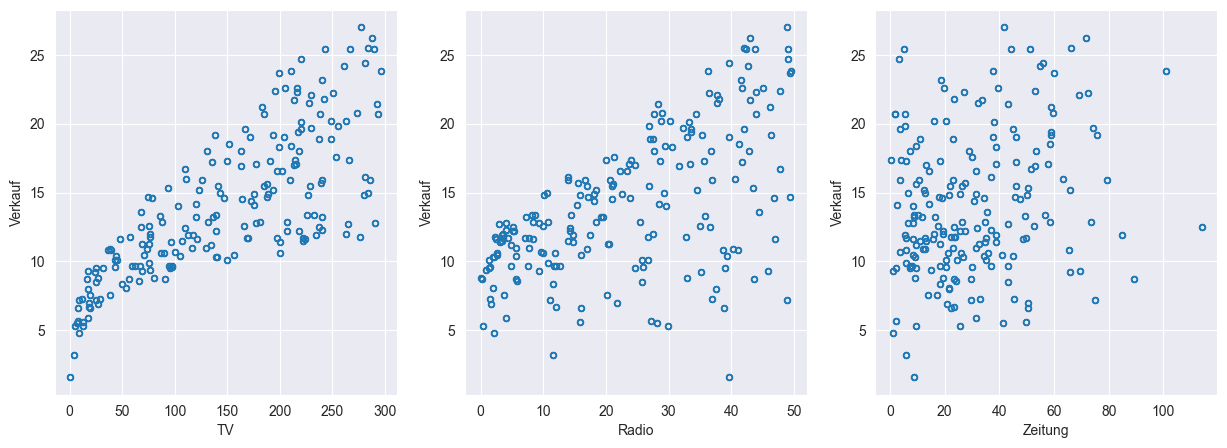

In [2]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
werbung.plot.scatter(x="TV", y="Verkauf", ax=ax1, marker="$\u25EF$")
ax1.set_xlabel("TV")
ax1.set_ylabel("Verkauf")

ax2 = fig.add_subplot(1, 3, 2)
werbung.plot.scatter(x="Radio", y="Verkauf", ax=ax2, marker="$\u25EF$")
ax2.set_xlabel("Radio")
ax2.set_ylabel("Verkauf")

ax3 = fig.add_subplot(1, 3, 3)
werbung.plot.scatter(x="Zeitung", y="Verkauf", ax=ax3, marker="$\u25EF$")
ax3.set_xlabel("Zeitung")
ax3.set_ylabel("Verkauf")

plt.show()

In [4]:
from scipy.optimize import minimize


def model(TV, Radio, Zeitung, a_TV, a_Radio, a_Zeitung, b):
    return a_TV * TV + a_Radio * Radio + a_Zeitung * Zeitung + b


def RSS(coeffs):
    residuen = werbung["Verkauf"] - model(werbung["TV"],
                                          werbung["Radio"],
                                          werbung["Zeitung"],
                                          coeffs[0],
                                          coeffs[1],
                                          coeffs[2],
                                          coeffs[3])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(4) + 0.1)
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 556.8252629034532
        x: [ 4.576e-02  1.885e-01 -1.038e-03  2.939e+00]
      nit: 7
      jac: [-1.526e-05 -7.629e-06  0.000e+00 -7.629e-06]
 hess_inv: [[ 2.118e-07 -6.061e-07 -3.436e-07  5.261e-07]
            [-6.061e-07  1.092e-05 -4.288e-06 -5.422e-06]
            [-3.436e-07 -4.288e-06  5.440e-06 -4.651e-07]
            [ 5.261e-07 -5.422e-06 -4.651e-07  4.836e-06]]
     nfev: 70
     njev: 14

In [5]:
def predict(TV, Radio, Zeitung):
    return model(TV, Radio, Zeitung, fit.x[0], fit.x[1], fit.x[2], fit.x[3])

In [9]:
# Residual standard Error 
p = 3  # Anzahl Prädiktoren
RSE = np.sqrt(1 / (werbung.shape[0] - p - 1) * fit.fun)  # fit.fun = RSS im Modell

print(RSE)

1.68551037341666


In [10]:
R_squared = (predict(werbung["TV"], werbung["Radio"], werbung["Zeitung"]).var() /
             werbung["Verkauf"].var())
print(R_squared)

0.8972098433604959


In [11]:
# Permutationstest
n_permutations = 1000
coefs_TV = []
coefs_Radio = []
coefs_Zeitung = []

for _ in range(n_permutations):
    Verkauf_permuted = np.random.permutation(werbung["Verkauf"])


    def RSS(coeffs):
        residuen = Verkauf_permuted - model(werbung["TV"],
                                            werbung["Radio"],
                                            werbung["Zeitung"],
                                            coeffs[0],
                                            coeffs[1],
                                            coeffs[2],
                                            coeffs[3])
        return (residuen ** 2).sum()


    fit_permuted = minimize(RSS, x0=np.zeros(4) + 0.1)
    coefs_TV.append(fit_permuted.x[0])
    coefs_Radio.append(fit_permuted.x[1])
    coefs_Zeitung.append(fit_permuted.x[2])

# p-Wert berechnen (zweiseitig)
coefs_TV = np.array(coefs_TV)
p_value_TV = 100 * np.mean(np.abs(coefs_TV) >= np.abs(fit.x[0]))

coefs_Radio = np.array(coefs_Radio)
p_value_Radio = 100 * np.mean(np.abs(coefs_Radio) >= np.abs(fit.x[1]))

coefs_Zeitung = np.array(coefs_Zeitung)
p_value_Zeitung = 100 * np.mean(np.abs(coefs_Zeitung) >= np.abs(fit.x[2]))

print(f"Beobachteter Koeffizient: {fit.x[0]:.4f}")
print(f"Resampling-basierter p-Wert: {p_value_TV:}")
print(f"Beobachteter Koeffizient: {fit.x[1]:.4f}")
print(f"Resampling-basierter p-Wert: {p_value_Radio:}")
print(f"Beobachteter Koeffizient: {fit.x[2]:.4f}")
print(f"Resampling-basierter p-Wert: {p_value_Zeitung:}")


Beobachteter Koeffizient: 0.0458
Resampling-basierter p-Wert: 0.0
Beobachteter Koeffizient: 0.1885
Resampling-basierter p-Wert: 0.0
Beobachteter Koeffizient: -0.0010
Resampling-basierter p-Wert: 96.0


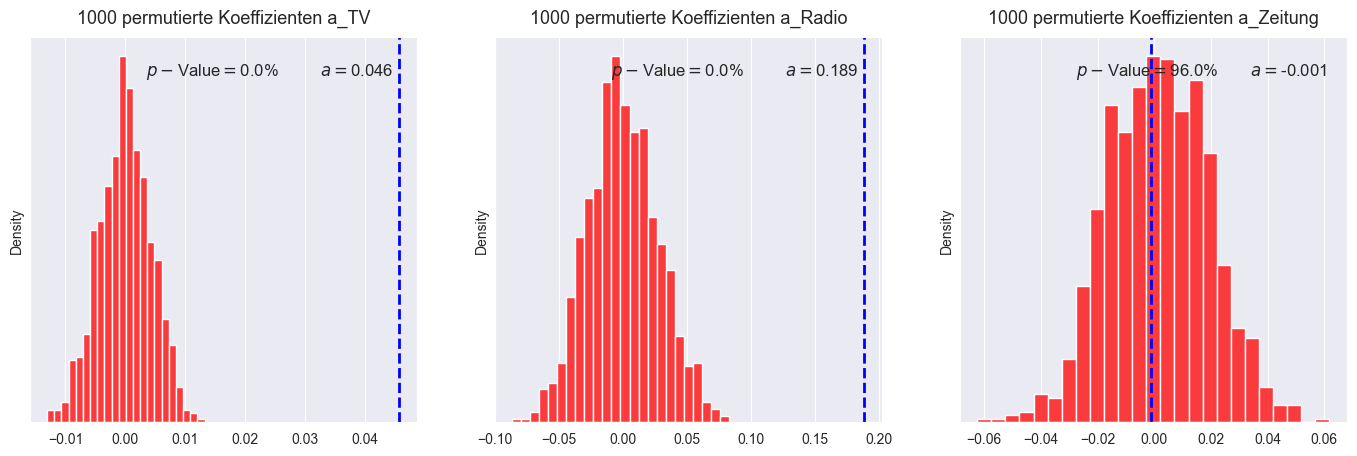

In [12]:
import seaborn as sns

fig = plt.figure(figsize=(17, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1 = sns.histplot(coefs_TV, stat="density", color="red")
ax1 = plt.axvline(fit.x[0], color="blue", lw=2, linestyle="dashed")
ax1 = plt.text(0.75, 0.9, r"$a=$" + "{m:1.3f}".format(m=fit.x[0]),
               fontsize=12, transform=plt.gca().transAxes)
ax1 = plt.text(0.3, 0.9, r"$p-$" + "Value" + r"$ = $" + "{p:1.1f}%".format(p=p_value_TV),
               fontsize=12, transform=plt.gca().transAxes)
ax1 = plt.title("1000 permutierte Koeffizienten a_TV",
                fontsize=13, pad=10)
ax1 = plt.xlabel("")
ax1 = plt.yticks([])

ax2 = fig.add_subplot(1, 3, 2)
ax2 = sns.histplot(coefs_Radio, stat="density", color="red")
ax2 = plt.axvline(fit.x[1], color="blue", lw=2, linestyle="dashed")
ax2 = plt.text(0.75, 0.9, r"$a=$" + "{m:1.3f}".format(m=fit.x[1]),
               fontsize=12, transform=plt.gca().transAxes)
ax2 = plt.text(0.3, 0.9, r"$p-$" + "Value" + r"$ = $" + "{p:1.1f}%".format(p=p_value_Radio),
               fontsize=12, transform=plt.gca().transAxes)
ax2 = plt.title("1000 permutierte Koeffizienten a_Radio",
                fontsize=13, pad=10)
ax2 = plt.xlabel("")
ax2 = plt.yticks([])

ax3 = fig.add_subplot(1, 3, 3)
ax3 = sns.histplot(coefs_Zeitung, stat="density", color="red")
ax3 = plt.axvline(fit.x[2], color="blue", lw=2, linestyle="dashed")
ax3 = plt.text(0.75, 0.9, r"$a=$" + "{m:1.3f}".format(m=fit.x[2]),
               fontsize=12, transform=plt.gca().transAxes)
ax3 = plt.text(0.3, 0.9, r"$p-$" + "Value" + r"$ = $" + "{p:1.1f}%".format(p=p_value_Zeitung),
               fontsize=12, transform=plt.gca().transAxes)
ax3 = plt.title("1000 permutierte Koeffizienten a_Zeitung",
                fontsize=13, pad=10)
ax3 = plt.xlabel("")
ax3 = plt.yticks([])

In [13]:
werbung.corr()
# Korrelationskoeffizient zwischen Prädiktoren Radio und Zeitung ist hoch 

,Unnamed: 0,TV,Radio,Zeitung,Verkauf
Unnamed: 0,1.000000,0.017715,-0.110680,-0.154944,-0.051616
TV,0.017715,1.000000,0.054809,0.056648,0.782224
Radio,-0.110680,0.054809,1.000000,0.354104,0.576223
Zeitung,-0.154944,0.056648,0.354104,1.000000,0.228299
Verkauf,-0.051616,0.782224,0.576223,0.228299,1.000000


In [14]:
def model(TV, Radio, a_TV, a_Radio, b):
    return a_TV * TV + a_Radio * Radio + b


def RSS(coeffs):
    residuen = werbung["Verkauf"] - model(werbung["TV"],
                                          werbung["Radio"],
                                          coeffs[0],
                                          coeffs[1],
                                          coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 0.2)
fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 556.9139800688515
        x: [ 4.575e-02  1.880e-01  2.921e+00]
      nit: 4
      jac: [-7.629e-06  7.629e-06  0.000e+00]
 hess_inv: [[ 3.419e-07 -1.084e-07 -4.775e-05]
            [-1.084e-07  1.143e-05 -2.500e-04]
            [-4.775e-05 -2.500e-04  1.534e-02]]
     nfev: 28
     njev: 7

In [15]:
def predict(TV, Radio):
    return model(TV, Radio, fit.x[0], fit.x[1], fit.x[2])

In [16]:
# Residual standard Error für einen Prädiktor 
p = 2  # Anzahl Prädiktoren
RSE = np.sqrt(1 / (werbung.shape[0] - p - 1) * fit.fun)  # fit.fun = RSS im Modell

print(RSE)

1.6813609125098625


In [17]:
R_squared = (predict(werbung["TV"], werbung["Radio"]).var() /
             werbung["Verkauf"].var())
print(R_squared)

0.8971934748759921


### <span style="color:rgb(160,0,86)">Was ist eine Kreuzvalidierung?</span>

Die bis anhin betrachteten Regressionsgrössen zur Beurteilung des Modells sind allesamt **stichprobenintern** (in-Sample). Sie werden auf Grundlage derselben Daten ermittelt, die zur Anpassung des Modells verwendet werden. 

Es ist sinnvoll einen Teil der ursprünglichen Daten beiseitezulegen, sie nicht zur Anpassung des Modells zu verwenden und das Modell dann auf diesen zurückgelegten Daten anzuwenden, um zu sehen, wie gut es abschneidet (out-of-Sample).

**Kreuzvalidierung**

- Legen Sie $1/k$ der Daten als **Hold-out-Stichprobe** beiseite.
- Trainieren Sie das Modell mit den übrigen Daten.
- Wenden Sie das Modell auf die **Hold-out-Stichprobe** an und erfallen Sie ein Gütemass zur Bewertung des Modells. Oft wird der **Root-Mean-Square-Error** $$\textbf{RMSE} = \sqrt{\frac{r_1^2+r_2^2+r_3^2+\ldots+r_n^2}{n}} $$ verwendet.
- Wiederholen Sie diese Schritte, bis all Daten jeweils einmal in der **Hold-out-Stichprobe** verwendet wurden.
- Bilden Sie den Mittelwert der ermittelten Gütemasse. 

In [19]:
idx = np.random.permutation(werbung.index)
m = len(idx)
werbung_1 = werbung.iloc[idx[0:int(0.25 * m)]]
werbung_2 = werbung.iloc[idx[int(0.25 * m):int(0.5 * m)]]
werbung_3 = werbung.iloc[idx[int(0.5 * m):int(0.75 * m)]]
werbung_4 = werbung.iloc[idx[int(0.75 * m):]]
print(werbung_1.shape[0], werbung_2.shape[0], werbung_3.shape[0], werbung_4.shape[0])

50 50 50 50


In [22]:
werbung_train = pd.concat([werbung_2, werbung_3, werbung_4])


def model(TV, Radio, a_TV, a_Radio, b):
    return a_TV * TV + a_Radio * Radio + b


def RSS(coeffs):
    residuen = werbung_train["Verkauf"] - model(werbung_train["TV"],
                                                werbung_train["Radio"],
                                                coeffs[0],
                                                coeffs[1],
                                                coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 0.2)


def predict(TV, Radio):
    return model(TV, Radio, fit.x[0], fit.x[1], fit.x[2])


RMSE_1 = np.sqrt(((werbung_1["Verkauf"] -
                   predict(werbung_1["TV"], werbung_1["Radio"])) ** 2).mean())

In [24]:
werbung_train = pd.concat([werbung_1, werbung_3, werbung_4])


def model(TV, Radio, a_TV, a_Radio, b):
    return a_TV * TV + a_Radio * Radio + b


def RSS(coeffs):
    residuen = werbung_train["Verkauf"] - model(werbung_train["TV"],
                                                werbung_train["Radio"],
                                                coeffs[0],
                                                coeffs[1],
                                                coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 0.2)


def predict(TV, Radio):
    return model(TV, Radio, fit.x[0], fit.x[1], fit.x[2])


RMSE_2 = np.sqrt(((werbung_2["Verkauf"] -
                   predict(werbung_2["TV"], werbung_2["Radio"])) ** 2).mean())

In [25]:
werbung_train = pd.concat([werbung_1, werbung_2, werbung_4])


def model(TV, Radio, a_TV, a_Radio, b):
    return a_TV * TV + a_Radio * Radio + b


def RSS(coeffs):
    residuen = werbung_train["Verkauf"] - model(werbung_train["TV"],
                                                werbung_train["Radio"],
                                                coeffs[0],
                                                coeffs[1],
                                                coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 0.2)


def predict(TV, Radio):
    return model(TV, Radio, fit.x[0], fit.x[1], fit.x[2])


RMSE_3 = np.sqrt(((werbung_3["Verkauf"] -
                   predict(werbung_3["TV"], werbung_3["Radio"])) ** 2).mean())

In [26]:
werbung_train = pd.concat([werbung_1, werbung_2, werbung_3])


def model(TV, Radio, a_TV, a_Radio, b):
    return a_TV * TV + a_Radio * Radio + b


def RSS(coeffs):
    residuen = werbung_train["Verkauf"] - model(werbung_train["TV"],
                                                werbung_train["Radio"],
                                                coeffs[0],
                                                coeffs[1],
                                                coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 0.2)


def predict(TV, Radio):
    return model(TV, Radio, fit.x[0], fit.x[1], fit.x[2])


RMSE_4 = np.sqrt(((werbung_4["Verkauf"] -
                   predict(werbung_4["TV"], werbung_4["Radio"])) ** 2).mean())

In [27]:
RMSE = (RMSE_1 + RMSE_2 + RMSE_3 + RMSE_4) / 4
print(RMSE_1, RMSE_2, RMSE_3, RMSE_4)
print(RMSE)

1.5307291899065933 2.1215461851330706 1.39982890356174 1.6823740758642114
1.6836195886164036


### <span style="color:rgb(160,0,86)">Wie können nicht metrische Merkmale berücksichtigt werden?</span>

- Die Werte eines **ordinalen Merkmales** werden in vernünftige Zahlen übersetzt.
- Die Werte eine **nominalen Merkmals** werden mit **Dummy-Variablen (0/1-Variablen)** abgebildet. Für $k$ Werte braucht es $k-1$ Dummy-Variablen. Ein Wert wird als **Baseline** bezeichnet.

Zum Beispiel können wir das Merkmal **Geschlecht G** mit den zwei Werten ***Frau*** und ***Mann*** mit einer Dummy-Variable abbilden:
$$\textbf{G} = \begin{cases}\;0&: \;\text{ für den Wert \textbf{Frau}}\\ \;1&: \;\text{ für den Wert \textbf{Mann}}\end{cases}$$
Mit dieser Codierung haben wir den Wert ***Frau*** als **Baseline** gewählt.

In [28]:
immo = pd.read_csv("Daten/house_sales.csv", sep="\t")
immo.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [29]:
pd.get_dummies(immo["PropertyType"]).head()

,Multiplex,Single Family,Townhouse
1,True,False,False
2,False,True,False
3,False,True,False
4,False,True,False
5,False,True,False


In [30]:
# Erster Wert ist die Basis
pd.get_dummies(immo["PropertyType"], drop_first=True).head()

,Single Family,Townhouse
1,False,False
2,True,False
3,True,False
4,True,False
5,True,False


In [31]:
teilmenge = ["SqFtTotLiving", "SqFtLot", "Bathrooms", "Bedrooms", "BldgGrade", "PropertyType"]
df = pd.get_dummies(immo[teilmenge], drop_first=True)
df.head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType_Single Family,PropertyType_Townhouse
1,2400,9373,3.00,6,7,False,False
2,3764,20156,3.75,4,10,True,False
3,2060,26036,1.75,4,8,True,False
4,3200,8618,3.75,5,7,True,False
5,1720,8620,1.75,4,7,True,False


In [32]:
df["PropertyType_Single Family"] = [1 if x else 0 for x in df["PropertyType_Single Family"]]
df["PropertyType_Townhouse"] = [1 if x else 0 for x in df["PropertyType_Townhouse"]]
df.head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType_Single Family,PropertyType_Townhouse
1,2400,9373,3.00,6,7,0,0
2,3764,20156,3.75,4,10,1,0
3,2060,26036,1.75,4,8,1,0
4,3200,8618,3.75,5,7,1,0
5,1720,8620,1.75,4,7,1,0


In [33]:
pred = df.columns
pred

Index(['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade',
       'PropertyType_Single Family', 'PropertyType_Townhouse'],
      dtype='object')

### <span style="color:rgb(160,0,86)">Wie finden wir ein gutes Modell?</span>

Oft stehen sehr viele Merkmale als Prädiktoren für eine Zielvariable zur Verfügung. Möglichst viele Prädiktoren zum Modell hinzuzufügen, bedeutet jedoch nicht unbedingt, dass wir ein besseres Modell erhalten. Wir sollten uns besser bei der Wahl des Modells an das Prinzip der **Sparsamkeit** orientieren. 

- <span style="color:rgb(160,0,86)">**Sofern Aspekte von Modellen gleich sind, sollte das einfachere Modell vorgezogen werden!**</span>

Eine Möglichkeit besteht darin, dass wir mit dem einfachsten Modell beginnen  und schrittweise den Prädiktor hinzufügen, der das Modell am besten erweitert (**Vorwärtsselektion**). Wenn die Verbesserung nicht mehr deutlich erkennbar ist, stoppen wir der Erweiterung des Modells:

 - Wähle in jedem Schritt das Modell mit dem kleinsten **RSS**-Wert und berechnet das **Informationskriterium nach Akaike** (*Akaike's Information Criteria*) $$\textbf{AIC} = 2\cdot \textbf{Anzahl Parameter im Model} + \pmb{n}\cdot \log(\,\textbf{RRS}\,/\pmb{n})$$ wobei $\pmb{n}$ die Anzahl der Daten in der Stichprobe ist.
 - Wiederhole diesen Schritt, bis der **AIC**-Wert nicht mehr abnimmt.   

In [35]:
def model(A_1, a_1, b):
    return a_1 * A_1 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[0]],
                                            coeffs[0],
                                            coeffs[1])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(2) + 1)
RSS_1 = fit.fun
AIC_1 = 2 * 2 + df.shape[0] * np.log(RSS_1 / df.shape[0])
fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1741354766255105.5
        x: [ 2.938e+02 -4.606e+04]
      nit: 8
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.338e-11 -2.304e-08]
            [-2.304e-08  5.788e-05]]
     nfev: 57
     njev: 19

In [36]:
def model(A_1, a_1, b):
    return a_1 * A_1 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[1]],
                                            coeffs[0],
                                            coeffs[1])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(2) + 2)
RSS_2 = fit.fun
AIC_2 = 2 * 2 + df.shape[0] * np.log(RSS_2 / df.shape[0])
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3306291983219952.0
        x: [ 1.823e+00  5.437e+05]
      nit: 7
      jac: [-7.046e+09  0.000e+00]
 hess_inv: [[ 2.321e-14 -5.832e-11]
            [-5.832e-11  4.704e-06]]
     nfev: 192
     njev: 60

In [37]:
def model(A_1, a_1, b):
    return a_1 * A_1 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[2]],
                                            coeffs[0],
                                            coeffs[1])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(2) + 1)
RSS_3 = fit.fun
AIC_3 = 2 * 2 + df.shape[0] * np.log(RSS_3 / df.shape[0])
fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2426264210041815.0
        x: [ 2.655e+05 -1.287e+04]
      nit: 8
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 8.323e-05 -2.067e-04]
            [-2.067e-04  5.275e-04]]
     nfev: 84
     njev: 28

In [38]:
def model(A_1, a_1, b):
    return a_1 * A_1 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[3]],
                                            coeffs[0],
                                            coeffs[1])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(2) + 1)
RSS_4 = fit.fun
AIC_4 = 2 * 2 + df.shape[0] * np.log(RSS_4 / df.shape[0])
fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3041673603174019.0
        x: [ 1.359e+05  1.067e+05]
      nit: 5
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 2.374e-05 -7.903e-05]
            [-7.903e-05  2.849e-04]]
     nfev: 51
     njev: 17

In [39]:
def model(A_1, a_1, b):
    return a_1 * A_1 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[4]],
                                            coeffs[0],
                                            coeffs[1])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(2) + 1)
RSS_5 = fit.fun
AIC_5 = 2 * 2 + df.shape[0] * np.log(RSS_5 / df.shape[0])
fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1831792342712349.5
        x: [ 2.205e+05 -1.128e+06]
      nit: 6
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.551e-05 -1.191e-04]
            [-1.191e-04  9.362e-04]]
     nfev: 45
     njev: 15

In [40]:
def model(A_1, A_2, a_1, a_2, b):
    return a_1 * A_1 + a_2 * A_2 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[5]],
                                            df[pred[6]],
                                            coeffs[0],
                                            coeffs[1],
                                            coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 1)
RSS_6 = fit.fun
AIC_6 = 2 * 3 + df.shape[0] * np.log(RSS_6 / df.shape[0])
fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3342567160248018.0
        x: [ 1.671e+04 -1.139e+05  5.582e+05]
      nit: 10
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[ 5.045e-04  2.077e-04 -4.724e-04]
            [ 2.077e-04  2.129e-04 -2.214e-04]
            [-4.724e-04 -2.214e-04  4.695e-04]]
     nfev: 108
     njev: 27

In [41]:
print(RSS_1, AIC_1)
print(RSS_2, AIC_2)
print(RSS_3, AIC_3)
print(RSS_4, AIC_4)
print(RSS_5, AIC_5)
print(RSS_6, AIC_6)

1741354766255105.5 568628.528110331
3306291983219952.0 583174.6135802439
2426264210041815.0 576153.5632754547
3041673603174019.0 581282.0771218222
1831792342712349.5 569777.2049102159
3342567160248018.0 583424.16976673


In [42]:
pred[0]

'SqFtTotLiving'

In [43]:
def model(A_1, A_2, a_1, a_2, b):
    return a_1 * A_1 + a_2 * A_2 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[0]],
                                            df[pred[1]],
                                            coeffs[0],
                                            coeffs[1],
                                            coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 2)
RSS_1 = fit.fun
AIC_1 = 2 * 3 + df.shape[0] * np.log(RSS_1 / df.shape[0])
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1741344877016373.5
        x: [ 2.931e+02  1.262e-02 -4.454e+04]
      nit: 9
      jac: [ 5.352e+09  2.562e+10  0.000e+00]
 hess_inv: [[ 1.249e-10 -2.235e-13 -2.964e-07]
            [-2.235e-13  2.724e-14  1.733e-10]
            [-2.964e-07  1.733e-10  7.309e-04]]
     nfev: 409
     njev: 99

In [44]:
def model(A_1, A_2, a_1, a_2, b):
    return a_1 * A_1 + a_2 * A_2 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[0]],
                                            df[pred[2]],
                                            coeffs[0],
                                            coeffs[1],
                                            coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.zeros(3) + 10)
RSS_2 = fit.fun
AIC_2 = 2 * 3 + df.shape[0] * np.log(RSS_2 / df.shape[0])
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1741313465045924.2
        x: [ 2.947e+02 -2.175e+03 -4.298e+04]
      nit: 10
      jac: [ 4.194e+08  1.678e+07  1.678e+07]
 hess_inv: [[ 4.642e-12 -1.567e-18 -1.052e-09]
            [-1.567e-18  2.728e-15 -2.819e-15]
            [-1.052e-09 -2.819e-15  3.192e-06]]
     nfev: 140
     njev: 35

In [45]:
def model(A_1, A_2, a_1, a_2, b):
    return a_1 * A_1 + a_2 * A_2 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[0]],
                                            df[pred[3]],
                                            coeffs[0],
                                            coeffs[1],
                                            coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.array([1, -0.4, 2]))
RSS_3 = fit.fun
AIC_3 = 2 * 3 + df.shape[0] * np.log(RSS_3 / df.shape[0])
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1683005883413932.0
        x: [ 3.347e+02 -7.004e+04  1.048e+05]
      nit: 9
      jac: [-9.831e+09 -1.678e+07  0.000e+00]
 hess_inv: [[ 1.835e-10 -1.614e-07  1.599e-07]
            [-1.614e-07  1.512e-04 -1.701e-04]
            [ 1.599e-07 -1.701e-04  2.537e-04]]
     nfev: 276
     njev: 66

In [46]:
def model(A_1, A_2, a_1, a_2, b):
    return a_1 * A_1 + a_2 * A_2 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[0]],
                                            df[pred[4]],
                                            coeffs[0],
                                            coeffs[1],
                                            coeffs[2])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.array([5, 5, 2]))
RSS_4 = fit.fun
AIC_4 = 2 * 3 + df.shape[0] * np.log(RSS_4 / df.shape[0])
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1578930248059325.0
        x: [ 1.821e+02  1.113e+05 -6.681e+05]
      nit: 22
      jac: [ 5.033e+07  0.000e+00  0.000e+00]
 hess_inv: [[ 3.878e-12 -2.108e-16 -1.128e-11]
            [-2.108e-16  3.314e-15 -2.708e-15]
            [-1.128e-11 -2.708e-15  3.307e-08]]
     nfev: 244
     njev: 61

In [47]:
def model(A_1, A_2, A_3, a_1, a_2, a_3, b):
    return a_1 * A_1 + a_2 * A_2 + a_3 * A_3 + b


def RSS(coeffs):
    residuen = immo["AdjSalePrice"] - model(df[pred[0]],
                                            df[pred[5]],
                                            df[pred[6]],
                                            coeffs[0],
                                            coeffs[1],
                                            coeffs[2],
                                            coeffs[3])
    return (residuen ** 2).sum()


fit = minimize(RSS, x0=np.array([5, -1, 1, 1]))
RSS_5 = fit.fun
AIC_5 = 2 * 4 + df.shape[0] * np.log(RSS_5 / df.shape[0])
fit

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1733549037769048.2
        x: [ 2.967e+02  6.869e+04  1.424e+05 -1.249e+05]
      nit: 9
      jac: [ 2.181e+10  1.678e+07  1.678e+07  5.033e+07]
 hess_inv: [[ 3.074e-11  3.970e-08  5.202e-08 -1.062e-07]
            [ 3.970e-08  2.134e-03  1.957e-03 -2.216e-03]
            [ 5.202e-08  1.957e-03  2.091e-03 -2.089e-03]
            [-1.062e-07 -2.216e-03 -2.089e-03  2.466e-03]]
     nfev: 347
     njev: 67

In [48]:
print(RSS_1, AIC_1)
print(RSS_2, AIC_2)
print(RSS_3, AIC_3)
print(RSS_4, AIC_4)
print(RSS_5, AIC_5)

1741344877016373.5 568630.3992693846
1741313465045924.2 568629.9900168517
1683005883413932.0 567857.3097632282
1578930248059325.0 566409.111175359
1733549037769048.2 568530.6036427714


In [49]:
pred[4]

'BldgGrade'

### <span style="color:rgb(160,0,86)">Aufgabe 1</span>

Vervollständigen Sie diese **Vorwärtsselektion**. 

In [ ]:
# To do!

### <span style="color:rgb(160,0,86)">Aufgabe 2</span>

Machen Sie eine multiple lineare Korrelationsananalyse mit dem Datensatz *Credit.csv* für die **Kreditwürdigkeit** (*rating*). 

In [ ]:
# To do!

![HSLU](Bilder/LogoHSLU.png)